In [1]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
%matplotlib inline
%load_ext autoreload
%autoreload 2
import random
import pdb
# from multiprocessing import Process, Manager
# from multiprocessing import set_start_method

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
import sys
sys.path.insert(0, '/home/nkotelevskii/github/corrected_l2hmc/l2hmc_pytorch/l2hmc/utils/')

In [4]:
from func_utils_pt import acl_spectrum, ESS
from distributions_pt import Gaussian
from layers_pt import Net
from dynamics_pt import Dynamics
from sampler_pt import propose
from notebook_utils_pt import get_hmc_samples

In [5]:
network = Net

In [6]:
x_dim = 2
mu = np.zeros(2,)
mu = torch.tensor(mu).to(device)
cov = np.array([[50.05, -49.95], [-49.95, 50.05]])
cov = torch.tensor(cov).to(device)

distribution = Gaussian(mu, cov)
dynamics = Dynamics(x_dim, distribution.get_energy_function(), T=10, eps=0.1, net_factory=network).to(device)

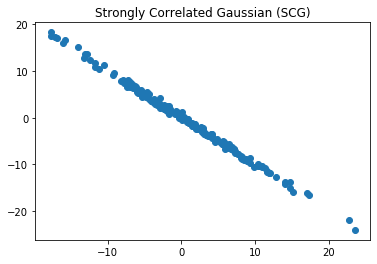

In [7]:
S = distribution.get_samples(200)
plt.title('Strongly Correlated Gaussian (SCG)')
plt.scatter(S[:, 0], S[:, 1])
plt.show()

In [8]:
n_steps = 5000
n_samples = 200
scale = torch.tensor(0.1, device=device)

In [9]:
optim = Adam(dynamics.parameters())

In [10]:
# [p for p in dynamics.parameters()]

In [11]:
dynamics.alpha

Parameter containing:
tensor(0.1000, device='cuda:0', requires_grad=True)

In [ ]:
scheduler = StepLR(optim, step_size=1000, gamma=0.96)

def criterion(v1, v2):
    return scale * (torch.mean(1.0 / v1) + torch.mean(1.0 / v2)) + (-torch.mean(v1) - torch.mean(v2)) / scale

for t in tqdm(range(n_steps)):    
    if(t==0):
        x = torch.randn(n_samples, x_dim, dtype=torch.float32, device=device)
    else:
        x = output[0]

    z = torch.randn_like(x, dtype=torch.float32, device=device)

    optim.zero_grad()
    Lx, _, px, output = propose(x, dynamics, do_mh_step=True)
    Lz, _, pz, _ = propose(z, dynamics, do_mh_step=False)

    v1 = (torch.sum((x - Lx)**2, dim=1) * px) + torch.tensor(1e-4, dtype=torch.float32, device=device)
    v2 = (torch.sum((z - Lz)**2, dim=1) * pz) + torch.tensor(1e-4, dtype=torch.float32, device=device)
    scale = torch.tensor(0.1, dtype=torch.float32, device=device)

    loss = criterion(v1, v2)
    loss.backward()

    optim.step()
#     pdb.set_trace()

    if t % 100 == 0:
        current_lr = None
        for param_group in optim.param_groups:
            current_lr = param_group['lr']
        print ('Step: %d / %d, Loss: %.2e, Acceptance sample: %.2f, LR: %.5f' % (t, n_steps, loss.item(), np.mean(px.cpu().detach().numpy()), current_lr))
    scheduler.step()
    optim.zero_grad()

  0%|          | 1/5000 [00:00<22:32,  3.70it/s]

Step: 0 / 5000, Loss: 3.59e+02, Acceptance sample: 0.37, LR: 0.00100


  2%|▏         | 101/5000 [00:27<22:47,  3.58it/s]

Step: 100 / 5000, Loss: -3.25e+02, Acceptance sample: 0.46, LR: 0.00100


  4%|▍         | 201/5000 [00:55<22:22,  3.57it/s]

Step: 200 / 5000, Loss: -2.10e+03, Acceptance sample: 0.21, LR: 0.00100


  6%|▌         | 301/5000 [01:23<21:28,  3.65it/s]

Step: 300 / 5000, Loss: -2.62e+03, Acceptance sample: 0.29, LR: 0.00100


  8%|▊         | 401/5000 [01:51<21:17,  3.60it/s]

Step: 400 / 5000, Loss: -2.88e+03, Acceptance sample: 0.28, LR: 0.00100


 10%|█         | 501/5000 [02:19<21:55,  3.42it/s]

Step: 500 / 5000, Loss: -3.50e+03, Acceptance sample: 0.30, LR: 0.00100


 12%|█▏        | 601/5000 [02:48<21:16,  3.45it/s]

Step: 600 / 5000, Loss: -3.47e+03, Acceptance sample: 0.35, LR: 0.00100


 14%|█▍        | 701/5000 [03:17<20:43,  3.46it/s]

Step: 700 / 5000, Loss: -3.90e+03, Acceptance sample: 0.32, LR: 0.00100


 16%|█▌        | 801/5000 [03:47<20:35,  3.40it/s]

Step: 800 / 5000, Loss: -3.76e+03, Acceptance sample: 0.36, LR: 0.00100


 18%|█▊        | 901/5000 [04:16<19:58,  3.42it/s]

Step: 900 / 5000, Loss: -4.83e+03, Acceptance sample: 0.38, LR: 0.00100


 19%|█▊        | 930/5000 [04:24<19:55,  3.40it/s]

In [ ]:
dynamics.alpha

In [ ]:
length_of_chains = 2000

In [ ]:
samples = torch.tensor(distribution.get_samples(n=n_samples), dtype=torch.float32, device=device)
final_samples = []

samples_ = samples
for t in tqdm(range(length_of_chains)):
    final_samples.append(samples_.cpu().numpy())
    _, _, _, samples_ = propose(samples_, dynamics, do_mh_step=True, trainable=False)
    samples_ = samples_[0].detach()

In [ ]:
L2HMC_samples = np.array(final_samples)
HMC_samples_1 = get_hmc_samples(2, 0.1, distribution.get_energy_function(), steps=length_of_chains, samples=samples)
HMC_samples_2 = get_hmc_samples(2, 0.15, distribution.get_energy_function(), steps=length_of_chains, samples=samples)
HMC_samples_3 = get_hmc_samples(2, 0.2, distribution.get_energy_function(), steps=length_of_chains, samples=samples)

In [ ]:
L2HMC_samples.shape

In [ ]:
HMC_samples_1.shape

In [ ]:
# from func_utils_pt import acl_spectrum, ESS

In [ ]:
scale = np.sqrt(np.trace(cov.cpu().detach().numpy()))
L2HMC = acl_spectrum(L2HMC_samples, scale=scale)
HMC1 = acl_spectrum(HMC_samples_1, scale=scale)
HMC2 = acl_spectrum(HMC_samples_2, scale=scale)
HMC3 = acl_spectrum(HMC_samples_3, scale=scale)

In [ ]:
points_to_plot = np.min([300, length_of_chains - 1])
xaxis = 10 * np.arange(points_to_plot)
plt.plot(xaxis, L2HMC[:points_to_plot], label='L2HMC')
plt.plot(xaxis, HMC1[:points_to_plot], label='HMC $\epsilon=0.1$')
plt.plot(xaxis, HMC2[:points_to_plot], label='HMC $\epsilon=0.15$')
plt.plot(xaxis, HMC3[:points_to_plot], label='HMC $\epsilon=0.2$')
plt.ylabel('Auto-correlation')
plt.xlabel('Gradient Computations')
plt.legend()
plt.show()

In [ ]:
print('ESS L2HMC: %.2e -- ESS HMC: %.2e -- Ratio: %d' % (ESS(L2HMC), ESS(HMC2), ESS(L2HMC) / ESS(HMC2)))

In [ ]:
num = 5
points_to_plot = np.min([50, length_of_chains - 1])

plt.scatter(S[:points_to_plot, 0], S[:points_to_plot, 1], label='True')
plt.plot(L2HMC_samples[:points_to_plot, num, 0], L2HMC_samples[:points_to_plot, num, 1], label='Sampled L2HMC', color='black', marker='o')
plt.plot(HMC_samples_1[:points_to_plot, num, 0], HMC_samples_1[:points_to_plot, num, 1], label='Sampled HMC $\epsilon=0.1$', color='red', marker='s', alpha=0.3)
plt.legend()
plt.show()